In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px
from scipy import ndimage
from pickle import load

In [2]:
from models.Hang2020 import Hang2020, spectral_network, spatial_network

In [4]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [5]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [6]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Load scalers for parameters

In [7]:
parameters_scalers = dict()
parameters_scalers['P'] = load((open(os.path.join(train_data_directory, 'standard_scaler_P.pkl'), 'rb')))
parameters_scalers['K'] = load((open(os.path.join(train_data_directory, 'standard_scaler_K.pkl'), 'rb')))
parameters_scalers['Mg'] = load((open(os.path.join(train_data_directory, 'standard_scaler_Mg.pkl'), 'rb')))
parameters_scalers['pH'] = load((open(os.path.join(train_data_directory, 'standard_scaler_pH.pkl'), 'rb')))

In [8]:
parameters_scalers['P'].mean_

array([70.30265589])

### Dataset definition

In [9]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False, parameters_scalers=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

        if parameters_scalers is not None:
            self.scaler_P = parameters_scalers['P']
            self.scaler_K = parameters_scalers['K']
            self.scaler_Mg = parameters_scalers['Mg']
            self.scaler_pH = parameters_scalers['pH']
        else:
            self.scaler_P = None
            self.scaler_K = None
            self.scaler_Mg = None
            self.scaler_pH = None

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']
            
            if self.scaler_P is not None:
                assert self.scaler_K is not None
                assert self.scaler_Mg is not None
                assert self.scaler_pH is not None
                
                P_gt = self.scaler_P.transform(np.array(P_gt).reshape(1, -1))[0][0]
                K_gt = self.scaler_K.transform(np.array(K_gt).reshape(1, -1))[0][0]
                Mg_gt = self.scaler_Mg.transform(np.array(Mg_gt).reshape(1, -1))[0][0]
                pH_gt = self.scaler_pH.transform(np.array(pH_gt).reshape(1, -1))[0][0]
                

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [10]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True, parameters_scalers=parameters_scalers)

In [11]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
BATCH_SIZE = 12
EPOCHS = 300

In [14]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

In [ ]:
model = Hang2020(bands=150, classes=1).to(device)

### Overfitting on single batch of data

In [31]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [32]:
train_data_single_batch = next(iter(train_dataloader))

In [33]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [34]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [35]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float)) # we are interested in final values (from las attention layer)

torch.Size([12, 1]) torch.Size([12, 1])


/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [36]:
output

tensor([[ 0.0187],
        [ 0.0917],
        [ 0.0461],
        [ 0.0504],
        [ 0.1395],
        [-0.0199],
        [-0.0950],
        [ 0.0822],
        [-0.0102],
        [ 0.2272],
        [ 0.0645],
        [-0.0050]], device='cuda:0', grad_fn=<AddBackward0>)

In [37]:
output.shape

torch.Size([12, 1])

In [38]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[-0.7697],
        [ 0.1593],
        [-0.3391],
        [-0.8138],
        [-0.3493],
        [-0.7426],
        [-0.0984],
        [-0.3323],
        [-0.4340],
        [-0.3900],
        [-0.8070],
        [-0.8714]], device='cuda:0', dtype=torch.float64)

In [39]:
loss_func(output, stacked_gt)

tensor(0.3771, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

#### Sprawdzenie czy inwersja skalowania działa właściwie

In [108]:
gt_df = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [109]:
train_data_single_batch['sample_index']

tensor([ 425, 1553,  804,   20,  516,  248,  152,  394, 1547, 1134,   78, 1023])

In [110]:
gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ 33.8],
       [ 46.5],
       [ 55.1],
       [ 70.5],
       [158. ],
       [ 37.1],
       [102. ],
       [110. ],
       [ 51.4],
       [106. ],
       [ 27.1],
       [ 49.6]])

In [111]:
scaler = getattr(train_dataset.dataset, f'scaler_P')
scaler

StandardScaler()

In [112]:
scaler.inverse_transform(stacked_gt.cpu())

array([[ 33.8],
       [ 46.5],
       [ 55.1],
       [ 70.5],
       [158. ],
       [ 37.1],
       [102. ],
       [110. ],
       [ 51.4],
       [106. ],
       [ 27.1],
       [ 49.6]])

In [113]:
scaler.inverse_transform(stacked_gt.cpu()) == gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

#### Właściwa pętla overfit

In [42]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)
scaler = getattr(train_dataset.dataset, f'scaler_P')

model = Hang2020(bands=150, classes=1).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
model.train()

for epoch in range(301):

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()
    
    output_cpu_inversed = scaler.inverse_transform(output_cpu)
    stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

    # Calculate MSE for each class
    mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}, MSE from unscaled values: {mse_inversed}')

epoch: 0, loss: 0.37684935331344604, MSE: [0.3768493], MSE from unscaled values: [327.87012]
epoch: 10, loss: 339.7909240722656, MSE: [339.7909], MSE from unscaled values: [295628.16]
epoch: 20, loss: 127.48943328857422, MSE: [127.48944], MSE from unscaled values: [110919.586]
epoch: 30, loss: 44.12042999267578, MSE: [44.120426], MSE from unscaled values: [38386.08]
epoch: 40, loss: 16.061935424804688, MSE: [16.061934], MSE from unscaled values: [13974.358]
epoch: 50, loss: 5.3983001708984375, MSE: [5.3983], MSE from unscaled values: [4696.681]
epoch: 60, loss: 0.9033737182617188, MSE: [0.9033737], MSE from unscaled values: [785.9619]
epoch: 70, loss: 0.33464640378952026, MSE: [0.33464637], MSE from unscaled values: [291.15228]
epoch: 80, loss: 0.39409011602401733, MSE: [0.39409006], MSE from unscaled values: [342.87003]
epoch: 90, loss: 0.2250736802816391, MSE: [0.22507368], MSE from unscaled values: [195.82076]
epoch: 100, loss: 0.09803949296474457, MSE: [0.09803949], MSE from unscal

### Training Definition

In [15]:
parameter = 'pH'

In [16]:
save_name = "checkpoint_state_dict_Hang2020_22_05_2022_Single_Parameter_Scaled__{}".format(parameter)
save_name

'checkpoint_state_dict_Hang2020_22_05_2022_Single_Parameter_Scaled__pH'

In [17]:
model_name = save_name+'.pth'

In [18]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [19]:
model = Hang2020(bands=150, classes=1).to(device)

In [20]:
wandb.watch(model, log="None", log_freq=20)

[]

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [22]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [23]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [24]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [25]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 8.30E-05


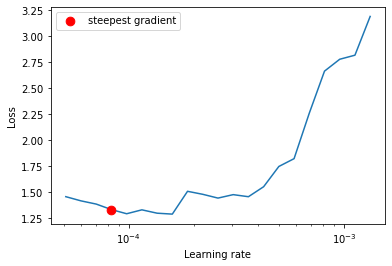

In [26]:
lr_finder.plot()
lr_finder.reset()

In [35]:
8.30E-05

8.3e-05

### Training

In [24]:
patience_scheduler_overfit = 8
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [25]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [26]:
config = wandb.config
config.model = 'Hang2020'
config.optimizer = 'AdamW'
config.loss_function = 'MSELoss'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = patience_scheduler_overfit
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'Hang2020 Parameter {} SCALED Training split:1000, Validation: 732. Scaled predicted variable. Model pretrained on Imagenet'.format(parameter)
config.parameter = parameter

In [27]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [ ]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')

for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    mse_inversed_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        output_cpu_inversed = scaler.inverse_transform(output_cpu)
        stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
        mse_train_list.append(mse)
        mse_inversed_train_list.append(mse_inversed)
        

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    avg_train_mse_inversed = torch.as_tensor(
        np.array(mse_inversed_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}, train MSE from unscaled values: {avg_train_mse_inversed}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse_inversed[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        mse_inversed_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()
            
            output_cpu_inversed = scaler.inverse_transform(output_cpu)
            stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
            mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
            mse_inversed_val_list.append(mse_inversed)


        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        avg_val_mse_inversed = torch.as_tensor(
            np.array(mse_inversed_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}, validation MSE from unscaled values: {avg_val_mse_inversed}')
        # using MSE from inversed values in W&B logger to make it compatible with previous runs in W&B
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse_inversed[0]}) 

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0, LR: 0.01, train loss: 1976.093505859375, train MSE: [1976.0933837890625], train MSE from unscaled values: [133.8131103515625]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 5.896430015563965, validation MSE: [5.896430969238281], validation MSE from unscaled values: [0.3992826044559479]
Validation loss decreased (inf --> 5.896430).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 3.1999237537384033, train MSE: [3.199923515319824], train MSE from unscaled values: [0.21668599545955658]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 3.036191701889038, validation MSE: [3.036191701889038], validation MSE from unscaled values: [0.20559874176979065]
Validation loss decreased (5.896430 --> 3.036192).  Saving model ...


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 1.8260183334350586, train MSE: [1.826018214225769], train MSE from unscaled values: [0.12365064024925232]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 1.2189843654632568, validation MSE: [1.2189843654632568], validation MSE from unscaled values: [0.0825447365641594]
Validation loss decreased (3.036192 --> 1.218984).  Saving model ...


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1.3882627487182617, train MSE: [1.3882626295089722], train MSE from unscaled values: [0.09400759637355804]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 1.5371813774108887, validation MSE: [1.5371812582015991], validation MSE from unscaled values: [0.10409177094697952]
EarlyStopping counter: 1 out of 19


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1.0805362462997437, train MSE: [1.080536127090454], train MSE from unscaled values: [0.07316957414150238]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 1.4158872365951538, validation MSE: [1.4158873558044434], validation MSE from unscaled values: [0.09587819874286652]
EarlyStopping counter: 2 out of 19


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1.0415171384811401, train MSE: [1.0415172576904297], train MSE from unscaled values: [0.07052737474441528]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 1.1057305335998535, validation MSE: [1.1057305335998535], validation MSE from unscaled values: [0.07487566024065018]
Validation loss decreased (1.218984 --> 1.105731).  Saving model ...


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 1.0120213031768799, train MSE: [1.0120213031768799], train MSE from unscaled values: [0.06853003799915314]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 1.0792640447616577, validation MSE: [1.0792641639709473], validation MSE from unscaled values: [0.07308343797922134]
Validation loss decreased (1.105731 --> 1.079264).  Saving model ...


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 0.9569475650787354, train MSE: [0.9569476246833801], train MSE from unscaled values: [0.06480064988136292]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 1.3708044290542603, validation MSE: [1.3708044290542603], validation MSE from unscaled values: [0.09282540529966354]
EarlyStopping counter: 1 out of 19


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 0.9160138368606567, train MSE: [0.9160138964653015], train MSE from unscaled values: [0.062028780579566956]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 1.1782408952713013, validation MSE: [1.1782410144805908], validation MSE from unscaled values: [0.07978576421737671]
EarlyStopping counter: 2 out of 19


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 0.9402770400047302, train MSE: [0.9402769804000854], train MSE from unscaled values: [0.06367179751396179]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 1.005457878112793, validation MSE: [1.0054579973220825], validation MSE from unscaled values: [0.06808558106422424]
Validation loss decreased (1.079264 --> 1.005458).  Saving model ...


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 0.9575801491737366, train MSE: [0.9575802087783813], train MSE from unscaled values: [0.06484349071979523]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 0.9997552633285522, validation MSE: [0.9997552633285522], validation MSE from unscaled values: [0.06769941747188568]
Validation loss decreased (1.005458 --> 0.999755).  Saving model ...


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 0.9543484449386597, train MSE: [0.9543483853340149], train MSE from unscaled values: [0.06462464481592178]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 1.1253228187561035, validation MSE: [1.125322937965393], validation MSE from unscaled values: [0.07620237022638321]
EarlyStopping counter: 1 out of 19


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 0.950261652469635, train MSE: [0.9502617716789246], train MSE from unscaled values: [0.06434790790081024]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 1.122328281402588, validation MSE: [1.122328281402588], validation MSE from unscaled values: [0.07599958777427673]
EarlyStopping counter: 2 out of 19


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.01, train loss: 0.9172638654708862, train MSE: [0.9172637462615967], train MSE from unscaled values: [0.0621134415268898]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 1.0282560586929321, validation MSE: [1.0282560586929321], validation MSE from unscaled values: [0.06962939351797104]
EarlyStopping counter: 3 out of 19


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.01, train loss: 0.9252820014953613, train MSE: [0.9252819418907166], train MSE from unscaled values: [0.06265638768672943]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 1.4846404790878296, validation MSE: [1.48464035987854], validation MSE from unscaled values: [0.10053391009569168]
EarlyStopping counter: 4 out of 19


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.01, train loss: 0.941522479057312, train MSE: [0.9415225386619568], train MSE from unscaled values: [0.06375613063573837]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 1.1885963678359985, validation MSE: [1.188596248626709], validation MSE from unscaled values: [0.0804869756102562]
EarlyStopping counter: 5 out of 19


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.01, train loss: 0.8938085436820984, train MSE: [0.8938085436820984], train MSE from unscaled values: [0.060525134205818176]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 1.221368670463562, validation MSE: [1.2213687896728516], validation MSE from unscaled values: [0.08270619809627533]
EarlyStopping counter: 6 out of 19


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.01, train loss: 0.9103231430053711, train MSE: [0.9103232026100159], train MSE from unscaled values: [0.061643440276384354]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 1.0162297487258911, validation MSE: [1.0162298679351807], validation MSE from unscaled values: [0.06881501525640488]
EarlyStopping counter: 7 out of 19


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.01, train loss: 0.8793220520019531, train MSE: [0.8793221116065979], train MSE from unscaled values: [0.059544168412685394]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 0.9681517481803894, validation MSE: [0.9681518077850342], validation MSE from unscaled values: [0.06555934995412827]
Validation loss decreased (0.999755 --> 0.968152).  Saving model ...


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.01, train loss: 0.8698359727859497, train MSE: [0.8698360323905945], train MSE from unscaled values: [0.05890180915594101]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 0.916823148727417, validation MSE: [0.916823148727417], validation MSE from unscaled values: [0.06208358705043793]
Validation loss decreased (0.968152 --> 0.916823).  Saving model ...


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.01, train loss: 0.8720663189888, train MSE: [0.8720663785934448], train MSE from unscaled values: [0.059052836149930954]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 0.9718151688575745, validation MSE: [0.9718151688575745], validation MSE from unscaled values: [0.06580741703510284]
EarlyStopping counter: 1 out of 19


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.01, train loss: 0.8852847814559937, train MSE: [0.8852847814559937], train MSE from unscaled values: [0.05994793772697449]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 0.9360809326171875, validation MSE: [0.9360809922218323], validation MSE from unscaled values: [0.06338765472173691]
EarlyStopping counter: 2 out of 19


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.01, train loss: 0.8723977208137512, train MSE: [0.8723978400230408], train MSE from unscaled values: [0.05907528102397919]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 0.9843618273735046, validation MSE: [0.9843618273735046], validation MSE from unscaled values: [0.06665703654289246]
EarlyStopping counter: 3 out of 19


epoch 23 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 23, LR: 0.01, train loss: 0.8827803730964661, train MSE: [0.8827803134918213], train MSE from unscaled values: [0.059778351336717606]


epoch 23 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 23, validation loss: 0.8915014266967773, validation MSE: [0.8915014266967773], validation MSE from unscaled values: [0.06036891043186188]
Validation loss decreased (0.916823 --> 0.891501).  Saving model ...


epoch 24 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 24, LR: 0.01, train loss: 0.8924447894096375, train MSE: [0.8924447298049927], train MSE from unscaled values: [0.0604327917098999]


epoch 24 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 24, validation loss: 0.9205836057662964, validation MSE: [0.9205836057662964], validation MSE from unscaled values: [0.06233823671936989]
EarlyStopping counter: 1 out of 19


epoch 25 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 25, LR: 0.01, train loss: 0.9035704731941223, train MSE: [0.9035705327987671], train MSE from unscaled values: [0.06118617579340935]


epoch 25 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 25, validation loss: 0.8953864574432373, validation MSE: [0.8953865170478821], validation MSE from unscaled values: [0.06063198670744896]
EarlyStopping counter: 2 out of 19


epoch 26 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 26, LR: 0.01, train loss: 0.8667923808097839, train MSE: [0.8667923212051392], train MSE from unscaled values: [0.058695707470178604]


epoch 26 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 26, validation loss: 0.9207184910774231, validation MSE: [0.9207184314727783], validation MSE from unscaled values: [0.062347374856472015]
EarlyStopping counter: 3 out of 19


epoch 27 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 27, LR: 0.01, train loss: 0.8500076532363892, train MSE: [0.8500076532363892], train MSE from unscaled values: [0.057559117674827576]


epoch 27 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 27, validation loss: 0.890045166015625, validation MSE: [0.8900452256202698], validation MSE from unscaled values: [0.060270294547080994]
Validation loss decreased (0.891501 --> 0.890045).  Saving model ...


epoch 28 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 28, LR: 0.01, train loss: 0.8740906715393066, train MSE: [0.8740907311439514], train MSE from unscaled values: [0.05918991565704346]


epoch 28 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 28, validation loss: 1.0070546865463257, validation MSE: [1.0070545673370361], validation MSE from unscaled values: [0.068193718791008]
EarlyStopping counter: 1 out of 19


epoch 29 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 29, LR: 0.01, train loss: 0.9087669253349304, train MSE: [0.9087669849395752], train MSE from unscaled values: [0.06153805926442146]


epoch 29 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 29, validation loss: 0.8983741402626038, validation MSE: [0.8983741402626038], validation MSE from unscaled values: [0.06083429977297783]
EarlyStopping counter: 2 out of 19


epoch 30 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 30, LR: 0.01, train loss: 0.9035820960998535, train MSE: [0.9035820960998535], train MSE from unscaled values: [0.061186958104372025]


epoch 30 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 30, validation loss: 0.9407339692115784, validation MSE: [0.9407340288162231], validation MSE from unscaled values: [0.06370273232460022]
EarlyStopping counter: 3 out of 19


epoch 31 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 31, LR: 0.01, train loss: 0.9006491899490356, train MSE: [0.9006493091583252], train MSE from unscaled values: [0.06098835542798042]


epoch 31 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 31, validation loss: 1.0032919645309448, validation MSE: [1.0032919645309448], validation MSE from unscaled values: [0.0679389163851738]
EarlyStopping counter: 4 out of 19


epoch 32 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 32, LR: 0.01, train loss: 0.85735684633255, train MSE: [0.8573569059371948], train MSE from unscaled values: [0.058056775480508804]


epoch 32 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 32, validation loss: 0.9820337891578674, validation MSE: [0.9820338487625122], validation MSE from unscaled values: [0.06649938970804214]
EarlyStopping counter: 5 out of 19


epoch 33 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 33, LR: 0.01, train loss: 0.8764098286628723, train MSE: [0.8764097690582275], train MSE from unscaled values: [0.059346962720155716]


epoch 33 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 33, validation loss: 0.8855680823326111, validation MSE: [0.8855681419372559], validation MSE from unscaled values: [0.059967126697301865]
Validation loss decreased (0.890045 --> 0.885568).  Saving model ...


epoch 34 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 34, LR: 0.01, train loss: 0.8733137845993042, train MSE: [0.8733137845993042], train MSE from unscaled values: [0.059137314558029175]


epoch 34 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 34, validation loss: 0.9162132143974304, validation MSE: [0.9162132143974304], validation MSE from unscaled values: [0.062042295932769775]
EarlyStopping counter: 1 out of 19


epoch 35 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 35, LR: 0.01, train loss: 0.8763152360916138, train MSE: [0.876315176486969], train MSE from unscaled values: [0.05934055894613266]


epoch 35 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 35, validation loss: 1.0290234088897705, validation MSE: [1.029023289680481], validation MSE from unscaled values: [0.06968133896589279]
EarlyStopping counter: 2 out of 19


epoch 36 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 36, LR: 0.01, train loss: 0.9030320048332214, train MSE: [0.9030318856239319], train MSE from unscaled values: [0.061149705201387405]


epoch 36 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 36, validation loss: 0.9970487952232361, validation MSE: [0.9970487356185913], validation MSE from unscaled values: [0.06751614809036255]
EarlyStopping counter: 3 out of 19


epoch 37 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 37, LR: 0.01, train loss: 0.9092327952384949, train MSE: [0.9092327356338501], train MSE from unscaled values: [0.06156959757208824]


epoch 37 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 37, validation loss: 0.8998114466667175, validation MSE: [0.8998115062713623], validation MSE from unscaled values: [0.06093161925673485]
EarlyStopping counter: 4 out of 19


epoch 38 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 38, LR: 0.01, train loss: 0.8805400133132935, train MSE: [0.8805400729179382], train MSE from unscaled values: [0.059626635164022446]


epoch 38 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 38, validation loss: 0.8836454153060913, validation MSE: [0.8836454749107361], validation MSE from unscaled values: [0.05983692780137062]
Validation loss decreased (0.885568 --> 0.883645).  Saving model ...


epoch 39 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 39, LR: 0.01, train loss: 0.8880203366279602, train MSE: [0.8880203366279602], train MSE from unscaled values: [0.060133181512355804]


epoch 39 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 39, validation loss: 0.8874278664588928, validation MSE: [0.887427806854248], validation MSE from unscaled values: [0.06009305641055107]
EarlyStopping counter: 1 out of 19


epoch 40 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 40, LR: 0.01, train loss: 0.870704710483551, train MSE: [0.8707047700881958], train MSE from unscaled values: [0.05896063148975372]


epoch 40 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 40, validation loss: 0.8876945376396179, validation MSE: [0.8876944780349731], validation MSE from unscaled values: [0.06011112406849861]
EarlyStopping counter: 2 out of 19


epoch 41 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 41, LR: 0.01, train loss: 0.8744348287582397, train MSE: [0.8744348883628845], train MSE from unscaled values: [0.05921322479844093]


epoch 41 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 41, validation loss: 0.8887328505516052, validation MSE: [0.8887328505516052], validation MSE from unscaled values: [0.06018143147230148]
EarlyStopping counter: 3 out of 19


epoch 42 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 42, LR: 0.01, train loss: 0.8719132542610168, train MSE: [0.8719133138656616], train MSE from unscaled values: [0.05904247239232063]


epoch 42 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 42, validation loss: 0.9296792149543762, validation MSE: [0.929679274559021], validation MSE from unscaled values: [0.06295415759086609]
EarlyStopping counter: 4 out of 19


epoch 43 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 43, LR: 0.01, train loss: 0.8716351389884949, train MSE: [0.8716351389884949], train MSE from unscaled values: [0.05902363732457161]


epoch 43 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 43, validation loss: 0.873778760433197, validation MSE: [0.873778760433197], validation MSE from unscaled values: [0.059168800711631775]
Validation loss decreased (0.883645 --> 0.873779).  Saving model ...


epoch 44 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 44, LR: 0.01, train loss: 0.8544638156890869, train MSE: [0.8544638752937317], train MSE from unscaled values: [0.05786086246371269]


epoch 44 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 44, validation loss: 0.879026472568512, validation MSE: [0.8790265321731567], validation MSE from unscaled values: [0.05952414125204086]
EarlyStopping counter: 1 out of 19


epoch 45 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 45, LR: 0.01, train loss: 0.8505988717079163, train MSE: [0.8505988717079163], train MSE from unscaled values: [0.05759914964437485]


epoch 45 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 45, validation loss: 0.8725128769874573, validation MSE: [0.872512936592102], validation MSE from unscaled values: [0.059083081781864166]
Validation loss decreased (0.873779 --> 0.872513).  Saving model ...


epoch 46 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 46, LR: 0.01, train loss: 0.8581345677375793, train MSE: [0.8581346273422241], train MSE from unscaled values: [0.05810944363474846]


epoch 46 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 46, validation loss: 0.8859859108924866, validation MSE: [0.8859860301017761], validation MSE from unscaled values: [0.05999542027711868]
EarlyStopping counter: 1 out of 19


epoch 47 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 47, LR: 0.01, train loss: 0.8676509261131287, train MSE: [0.8676510453224182], train MSE from unscaled values: [0.0587538480758667]


epoch 47 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 47, validation loss: 0.8982952833175659, validation MSE: [0.8982954025268555], validation MSE from unscaled values: [0.06082896888256073]
EarlyStopping counter: 2 out of 19


epoch 48 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 48, LR: 0.01, train loss: 0.8543389439582825, train MSE: [0.8543389439582825], train MSE from unscaled values: [0.05785241350531578]


epoch 48 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 48, validation loss: 0.9208338260650635, validation MSE: [0.9208338856697083], validation MSE from unscaled values: [0.06235518679022789]
EarlyStopping counter: 3 out of 19


epoch 49 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 49, LR: 0.01, train loss: 0.8617069125175476, train MSE: [0.8617069125175476], train MSE from unscaled values: [0.058351337909698486]


epoch 49 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 49, validation loss: 0.8613008260726929, validation MSE: [0.8613008260726929], validation MSE from unscaled values: [0.05832384154200554]
Validation loss decreased (0.872513 --> 0.861301).  Saving model ...


epoch 50 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 50, LR: 0.01, train loss: 0.8720949292182922, train MSE: [0.8720949292182922], train MSE from unscaled values: [0.05905477702617645]


epoch 50 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 50, validation loss: 0.8627364039421082, validation MSE: [0.8627364635467529], validation MSE from unscaled values: [0.0584210529923439]
EarlyStopping counter: 1 out of 19


epoch 51 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 51, LR: 0.01, train loss: 0.8604504466056824, train MSE: [0.8604503870010376], train MSE from unscaled values: [0.058266256004571915]


epoch 51 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 51, validation loss: 0.9281433820724487, validation MSE: [0.9281433820724487], validation MSE from unscaled values: [0.06285014748573303]
EarlyStopping counter: 2 out of 19


epoch 52 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 52, LR: 0.01, train loss: 0.855657696723938, train MSE: [0.8556577563285828], train MSE from unscaled values: [0.05794171243906021]


epoch 52 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 52, validation loss: 0.8675180077552795, validation MSE: [0.8675180673599243], validation MSE from unscaled values: [0.05874484032392502]
EarlyStopping counter: 3 out of 19


epoch 53 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 53, LR: 0.01, train loss: 0.8552634716033936, train MSE: [0.8552634119987488], train MSE from unscaled values: [0.05791502073407173]


epoch 53 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 53, validation loss: 0.8971453905105591, validation MSE: [0.8971453905105591], validation MSE from unscaled values: [0.060751091688871384]
EarlyStopping counter: 4 out of 19


epoch 54 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 54, LR: 0.01, train loss: 0.8681437969207764, train MSE: [0.8681438565254211], train MSE from unscaled values: [0.05878721550107002]


epoch 54 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 54, validation loss: 0.8734263777732849, validation MSE: [0.8734263181686401], validation MSE from unscaled values: [0.059144940227270126]
EarlyStopping counter: 5 out of 19


epoch 55 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 55, LR: 0.01, train loss: 0.8542976379394531, train MSE: [0.8542976975440979], train MSE from unscaled values: [0.057849619537591934]


epoch 55 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 55, validation loss: 0.880025327205658, validation MSE: [0.8800254464149475], validation MSE from unscaled values: [0.05959179252386093]
EarlyStopping counter: 6 out of 19


epoch 56 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 56, LR: 0.01, train loss: 0.8519240617752075, train MSE: [0.8519240021705627], train MSE from unscaled values: [0.0576888844370842]


epoch 56 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 56, validation loss: 0.8550326824188232, validation MSE: [0.855032742023468], validation MSE from unscaled values: [0.057899389415979385]
Validation loss decreased (0.861301 --> 0.855033).  Saving model ...


epoch 57 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 57, LR: 0.01, train loss: 0.8570228219032288, train MSE: [0.8570228219032288], train MSE from unscaled values: [0.058034155517816544]


epoch 57 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 57, validation loss: 0.8674448728561401, validation MSE: [0.8674448728561401], validation MSE from unscaled values: [0.05873989686369896]
EarlyStopping counter: 1 out of 19


epoch 58 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 58, LR: 0.01, train loss: 0.8533135652542114, train MSE: [0.8533135652542114], train MSE from unscaled values: [0.057782988995313644]


epoch 58 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 58, validation loss: 0.8620923757553101, validation MSE: [0.8620924353599548], validation MSE from unscaled values: [0.05837743729352951]
EarlyStopping counter: 2 out of 19


epoch 59 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 59, LR: 0.01, train loss: 0.835905134677887, train MSE: [0.8359052538871765], train MSE from unscaled values: [0.05660415068268776]


epoch 59 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 59, validation loss: 0.9258784055709839, validation MSE: [0.9258784651756287], validation MSE from unscaled values: [0.06269676983356476]
EarlyStopping counter: 3 out of 19


epoch 60 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 60, LR: 0.01, train loss: 0.8447890281677246, train MSE: [0.8447889685630798], train MSE from unscaled values: [0.05720572918653488]


epoch 60 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 60, validation loss: 0.8648185729980469, validation MSE: [0.8648186326026917], validation MSE from unscaled values: [0.05856205150485039]
EarlyStopping counter: 4 out of 19


epoch 61 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 61, LR: 0.01, train loss: 0.8382336497306824, train MSE: [0.8382336497306824], train MSE from unscaled values: [0.05676182731986046]


epoch 61 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 61, validation loss: 0.9027596712112427, validation MSE: [0.9027597308158875], validation MSE from unscaled values: [0.06113126501441002]
EarlyStopping counter: 5 out of 19


epoch 62 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 62, LR: 0.01, train loss: 0.8413258194923401, train MSE: [0.8413257598876953], train MSE from unscaled values: [0.05697121098637581]


epoch 62 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 62, validation loss: 0.9120732545852661, validation MSE: [0.9120732545852661], validation MSE from unscaled values: [0.06176194176077843]
EarlyStopping counter: 6 out of 19


epoch 63 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 63, LR: 0.01, train loss: 0.858258843421936, train MSE: [0.8582589030265808], train MSE from unscaled values: [0.058117855340242386]


epoch 63 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 63, validation loss: 0.8599916696548462, validation MSE: [0.859991729259491], validation MSE from unscaled values: [0.05823519080877304]
EarlyStopping counter: 7 out of 19


epoch 64 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 64, LR: 0.01, train loss: 0.8359363675117493, train MSE: [0.8359364867210388], train MSE from unscaled values: [0.05660626292228699]


epoch 64 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 64, validation loss: 0.8907192349433899, validation MSE: [0.8907192349433899], validation MSE from unscaled values: [0.060315944254398346]
EarlyStopping counter: 8 out of 19


epoch 65 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 65, LR: 0.01, train loss: 0.8331292867660522, train MSE: [0.833129346370697], train MSE from unscaled values: [0.05641617253422737]


epoch 65 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 65, validation loss: 0.8528786301612854, validation MSE: [0.8528786301612854], validation MSE from unscaled values: [0.05775352939963341]
Validation loss decreased (0.855033 --> 0.852879).  Saving model ...


epoch 66 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 66, LR: 0.01, train loss: 0.8280655145645142, train MSE: [0.8280655145645142], train MSE from unscaled values: [0.056073274463415146]


epoch 66 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 66, validation loss: 0.872128427028656, validation MSE: [0.8721284866333008], validation MSE from unscaled values: [0.059057045727968216]
EarlyStopping counter: 1 out of 19


epoch 67 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 67, LR: 0.01, train loss: 0.8509382605552673, train MSE: [0.8509382009506226], train MSE from unscaled values: [0.05762212723493576]


epoch 67 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 67, validation loss: 0.8578912019729614, validation MSE: [0.8578912615776062], validation MSE from unscaled values: [0.058092959225177765]
EarlyStopping counter: 2 out of 19


epoch 68 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 68, LR: 0.01, train loss: 0.8300268054008484, train MSE: [0.8300268054008484], train MSE from unscaled values: [0.05620608851313591]


epoch 68 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 68, validation loss: 0.8725401163101196, validation MSE: [0.8725402355194092], validation MSE from unscaled values: [0.059084925800561905]
EarlyStopping counter: 3 out of 19


epoch 69 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 69, LR: 0.01, train loss: 0.852669358253479, train MSE: [0.8526692986488342], train MSE from unscaled values: [0.05773935094475746]


epoch 69 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 69, validation loss: 0.9093642830848694, validation MSE: [0.9093643426895142], validation MSE from unscaled values: [0.06157851219177246]
EarlyStopping counter: 4 out of 19


epoch 70 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 70, LR: 0.01, train loss: 0.8517422676086426, train MSE: [0.8517422676086426], train MSE from unscaled values: [0.05767656862735748]


epoch 70 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 70, validation loss: 0.8538601398468018, validation MSE: [0.8538601398468018], validation MSE from unscaled values: [0.057819996029138565]
EarlyStopping counter: 5 out of 19


epoch 71 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 71, LR: 0.01, train loss: 0.8303012847900391, train MSE: [0.8303012847900391], train MSE from unscaled values: [0.056224677711725235]


epoch 71 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 71, validation loss: 0.862404465675354, validation MSE: [0.862404465675354], validation MSE from unscaled values: [0.05839857459068298]
EarlyStopping counter: 6 out of 19


epoch 72 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 72, LR: 0.01, train loss: 0.8410360813140869, train MSE: [0.8410361409187317], train MSE from unscaled values: [0.05695158615708351]


epoch 72 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 72, validation loss: 0.8898555040359497, validation MSE: [0.8898555040359497], validation MSE from unscaled values: [0.0602574497461319]
EarlyStopping counter: 7 out of 19


epoch 73 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 73, LR: 0.01, train loss: 0.8365216255187988, train MSE: [0.836521565914154], train MSE from unscaled values: [0.056645892560482025]


epoch 73 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 73, validation loss: 0.8916495442390442, validation MSE: [0.891649603843689], validation MSE from unscaled values: [0.06037893891334534]
EarlyStopping counter: 8 out of 19


epoch 74 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 74, LR: 0.01, train loss: 0.8665702939033508, train MSE: [0.8665703535079956], train MSE from unscaled values: [0.05868067964911461]


epoch 74 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 74, validation loss: 0.8794600367546082, validation MSE: [0.8794599771499634], validation MSE from unscaled values: [0.05955351144075394]
EarlyStopping counter: 9 out of 19


epoch 75 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 75, LR: 0.006, train loss: 0.8548471331596375, train MSE: [0.8548471927642822], train MSE from unscaled values: [0.05788682401180267]


epoch 75 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 75, validation loss: 0.8995023369789124, validation MSE: [0.8995023369789124], validation MSE from unscaled values: [0.060910698026418686]
EarlyStopping counter: 10 out of 19


epoch 76 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 76, LR: 0.006, train loss: 0.8518456816673279, train MSE: [0.8518456816673279], train MSE from unscaled values: [0.057683587074279785]


epoch 76 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 76, validation loss: 0.8628951907157898, validation MSE: [0.8628951907157898], validation MSE from unscaled values: [0.058431800454854965]
EarlyStopping counter: 11 out of 19


epoch 77 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 77, LR: 0.006, train loss: 0.8273980617523193, train MSE: [0.8273981213569641], train MSE from unscaled values: [0.056028082966804504]


epoch 77 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 77, validation loss: 0.8780185580253601, validation MSE: [0.8780186176300049], validation MSE from unscaled values: [0.05945590138435364]
EarlyStopping counter: 12 out of 19


epoch 78 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 78, LR: 0.006, train loss: 0.8263567686080933, train MSE: [0.826356828212738], train MSE from unscaled values: [0.055957574397325516]


epoch 78 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 78, validation loss: 0.8660464286804199, validation MSE: [0.8660464286804199], validation MSE from unscaled values: [0.05864519998431206]
EarlyStopping counter: 13 out of 19


epoch 79 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 79, LR: 0.006, train loss: 0.8123310208320618, train MSE: [0.812330961227417], train MSE from unscaled values: [0.05500779673457146]


epoch 79 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 79, validation loss: 0.8642639517784119, validation MSE: [0.8642639517784119], validation MSE from unscaled values: [0.05852450057864189]
EarlyStopping counter: 14 out of 19


epoch 80 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 80, LR: 0.006, train loss: 0.809582531452179, train MSE: [0.809582531452179], train MSE from unscaled values: [0.0548216812312603]


epoch 80 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 80, validation loss: 0.8719057440757751, validation MSE: [0.8719057440757751], validation MSE from unscaled values: [0.059041958302259445]
EarlyStopping counter: 15 out of 19


epoch 81 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 81, LR: 0.006, train loss: 0.8137623071670532, train MSE: [0.8137622475624084], train MSE from unscaled values: [0.05510472133755684]


epoch 81 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 81, validation loss: 0.8670542240142822, validation MSE: [0.867054283618927], validation MSE from unscaled values: [0.05871344730257988]
EarlyStopping counter: 16 out of 19


epoch 82 training data:   0%|          | 0/83 [00:00<?, ?it/s]

#### Saving model state dict and loading

In [ ]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [ ]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_Hang2020_22_05_2022_Single_Parameter_Scaled__pH.pth

In [ ]:
# load saved model
modelLoad = Hang2020(bands=150, classes=1).to(device)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_Hang2020_22_05_2022_Single_Parameter_Scaled__pH.pth')))

In [ ]:
modelLoad = modelLoad.to(device)